# VAE Using Extended Kalman Filter for Speech Recognition using TIMIT  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic:
VAE: https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py 

TIMIT: https://github.com/jackjhliu/Pytorch-End-to-End-ASR-on-TIMIT

EKF: https://github.com/jnez71/kalmaNN

We are using TIMIT data.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com

In [2]:
import argparse
import data
import eval_utils
import logging, sys
import matplotlib.pyplot as plt
import os
from prepare_data import prepare_csv
from show_history import plotLearning
import time 
import timeit
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision
from torchvision import transforms
import torch.optim as optim
import yaml

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Prepare Data from Raw WAV files: TIMIT


In [2]:
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

prepare_csv("../TIMIT/TIMIT_DATA/")

TRAIN.csv is created.
DEV.csv is created.
TEST.csv is created.
Data preparation is complete !


## MultiLayer GRUCell

In [3]:
class MultiLayerGRUCell(nn.Module):
    """
    Stack multiple GRU cells. For DecoderRNN.
    """
    def __init__(self, input_size, hidden_size, num_layers, drop_p):
        """
        Args:
            input_size (integer): Input size of GRU cells.
            hidden_size (integer): Hidden layer size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(MultiLayerGRUCell, self).__init__()

        self.cells = nn.ModuleList([])
        for i in range(num_layers):
            if i==0:
                self.cells.append(nn.GRUCell(input_size, hidden_size))
            else:
                self.cells.append(nn.GRUCell(hidden_size, hidden_size))
        self.dropouts = nn.ModuleList([nn.Dropout(drop_p) for _ in range(num_layers-1)])
        self.num_layers = num_layers

    def forward(self, x, h):
        """
        One step forward pass.
        
        Args:
            x (torch.FloatTensor, [batch_size, input_size]): The input features of current time step.
            h (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of previous time step.
            
        Returns:
            outputs (torch.FloatTensor, [num_layers, batch_size, hidden_size]): The hidden state of current time step.
        """
        outputs = []
        for i in range(self.num_layers):
            if i==0:
                x = self.cells[i](x, h[i])
            else:
                x = self.cells[i](self.dropouts[i-1](x), h[i])
            outputs.append(x)
        outputs = torch.stack(outputs, dim=0)
        return outputs

#### Load Config & Clean up Previous Run Stats

In [4]:
cfgFile = "config/default.yaml" 
import shutil

with open(cfgFile) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
        
if not cfg['logdir']:
    save_path = os.path.splitext(cfgFile)[0]
    
if os.path.exists(save_path):
    shutil.rmtree(save_path)

os.mkdir(save_path)

In [5]:
### Set the constants

In [6]:
gpu_id = 0
workers = 0
ckpt_freq = 10

### Encoder  RNN

D_in: Input Dimension
H: 
D_out: Output Dimension

In [7]:
class EncoderRNN(nn.Module):
    """
    A bidirectional RNN. It takes FBANK features and outputs the output state vectors of every time step.
    """
    def __init__(self, n_words, hidden_size, num_layers, drop_p):
        """
        Args:
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(EncoderRNN, self).__init__()
        self.embed = nn.Linear(n_words, hidden_size)   # 240 is the dimension of acoustic features.
        self.rnn = nn.GRU(hidden_size,
                          hidden_size,
                          batch_first=True,
                          bidirectional=True,
                          num_layers=num_layers,
                          dropout=drop_p)
        # The initial state is a trainable vector.
        self.init_state = torch.nn.Parameter(torch.randn([2 * num_layers, 1, hidden_size]))

    def forward(self, xs, xlens):
        """
        We pack the padded sequences because it is especially important for bidirectional RNN to work properly. The RNN 
        in opposite direction can ignore the first few <PAD> tokens after packing.

        Args:
            xs (torch.FloatTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.

        Returns:
            outputs (PackedSequence): The packed output states.
        """
        #print("EncoderRNN forward")
        batch_size = xs.shape[0]
        xs = self.embed(xs)
        xs = rnn_utils.pack_padded_sequence(xs,
                                            xlens,
                                            batch_first=True,
                                            enforce_sorted=False)
        outputs, _ = self.rnn(xs, self.init_state.repeat([1, batch_size, 1]))
        #print("EncoderRNN outputs = ", outputs)
        return outputs

### Decoder RNN

In [8]:
class DecoderRNN(nn.Module):
    """
    A decoder network which applies Luong attention (https://arxiv.org/abs/1508.04025).
    """
    def __init__(self, n_words, hidden_size, num_layers, activation, drop_p):
        """
        Args:
            n_words (integer): Size of the target vocabulary.
            hidden_size (integer): Size of GRU cells.
            num_layers (integer): Number of GRU layers.
            activation: activation function type; 'logistic', 'tanh', or 'relu'
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(DecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(n_words, hidden_size)
        self.cell = MultiLayerGRUCell(2 * hidden_size,
                                      hidden_size,
                                      num_layers=num_layers,
                                      drop_p=drop_p)
        # The initial states are trainable vectors.
        self.init_h = torch.nn.Parameter(torch.randn([num_layers, 1, hidden_size]))
        self.init_y = torch.nn.Parameter(torch.randn([1, hidden_size]))

        self.attn_W = nn.Linear(2 * hidden_size, hidden_size)
        self.attn_U = nn.Linear(hidden_size, hidden_size)
        self.attn_v = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(3 * hidden_size, hidden_size)
        self.drop = nn.Dropout(drop_p)
        self.classifier = nn.Linear(hidden_size, n_words)
        self.activation = activation

    def forward(self, encoder_states, ground_truths=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            encoder_states (PackedSequence): Packed output state vectors from the EncoderRNN.
            ground_truths (torch.LongTensor, [batch_size, padded_len_tgt]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truths.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            all_attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("DecoderRNN forward")
        states, states_lengths  = rnn_utils.pad_packed_sequence(
            encoder_states, batch_first=True)   # [batch_size, padded_len_src, 2 * hidden_size], [batch_size]
        batch_size = states.shape[0]
        h = self.init_h.repeat([1, batch_size, 1])   # [num_layers, batch_size, hidden_size]
        y = self.init_y.repeat([batch_size, 1])      # [batch_size, hidden_size]

        if ground_truths is None:
            all_attn_weights = []
            predictions = [torch.full([batch_size], 3, dtype=torch.int64).cuda()]   # The first predicted word is always <s> (ID=3).
            # Unrolling the forward pass
            for time_step in range(100):   # Empirically set max_length=100
                x = predictions[-1]                           # [batch_size]
                x = self.embed(x)                             # [batch_size, hidden_size]
                h = self.cell(torch.cat([y, x], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, attn_weights = self.apply_attn(
                    states, states_lengths, h[-1])            # [batch_size, 2 * hidden_size], [batch_size, length_of_encoder_states]
                y = torch.cat([attns, h[-1]], dim=-1)         # [batch_size, 3 * hidden_size]
                y = self.apply_activation(self.activation, self.fc(y))                        # [batch_size, hidden_size]

                all_attn_weights.append(attn_weights)
                # Output
                logits = self.classifier(y)                   # [batch_size, n_words]
                # TODO: Adopt Beam Search to replace Greedy Search
                samples = torch.argmax(logits, dim=-1)        # [batch_size]
                predictions.append(samples)
            all_attn_weights = torch.stack(all_attn_weights, dim=1)   # [batch_size, max_length, length_of_encoder_states]
            predictions = torch.stack(predictions, dim=-1)    # [batch_size, max_length]
            #print("DecoderRNN predictions = ", predictions)
            return predictions, all_attn_weights
        else:
            xs = self.embed(ground_truths[:, :-1])   # [batch_size, padded_len_tgt, hidden_size]
            outputs = []
            # Unrolling the forward pass
            for time_step in range(xs.shape[1]):
                h = self.cell(torch.cat([y, xs[:,time_step]], dim=-1), h)   # [num_layers, batch_size, hidden_size]
                attns, _ = self.apply_attn(states, states_lengths, h[-1])       # [batch_size, 2 * hidden_size]
                y = torch.cat([attns, h[-1]], dim=-1)                           # [batch_size, 3 * hidden_size]
                y = self.apply_activation(self.activation, self.fc(y))                                          # [batch_size, hidden_size]
                outputs.append(y)

            # Output
            outputs = torch.stack(outputs, dim=1)   # [batch_size, padded_len_tgt, hidden_size]
            outputs = self.drop(outputs)
            outputs = self.classifier(outputs)      # [batch_size, padded_len_tgt, n_words]
            #print("DecoderRNN outputs = ", outputs)
            

            # Compute loss
            mask = ground_truths[:, 1:].gt(0)       # [batch_size, padded_len_tgt]
            loss = nn.CrossEntropyLoss()(outputs[mask], ground_truths[:, 1:][mask])
            return loss

    def apply_attn(self, source_states, source_lengths, target_states):
        """
        Apply attention.

        Args:
            source_states (torch.FloatTensor, [batch_size, padded_length_of_encoder_states, 2 * hidden_size]):
                The padded encoder output states.
            source_lengths (torch.LongTensor, [batch_size]): The length of encoder output states before padding.
            target_state (torch.FloatTensor, [batch_size, hidden_size]): The decoder output state (of previous time step).

        Returns:
            attns (torch.FloatTensor, [batch_size, hidden_size]):
                The attention result (weighted sum of Encoder output states).
            attn_weights (torch.FloatTensor, [batch_size, padded_length_of_encoder_states]): The attention alignment weights.
        """
        # A two-layer network used for project every pair of [source_state, target_state].
        attns = self.attn_W(source_states) + self.attn_U(target_states).unsqueeze(1)   # [batch_size, padded_len_src, hidden_size]
        attns = self.attn_v(self.apply_activation(self.activation, attns)).squeeze(2)                   # [batch_size, padded_len_src]

        # Create a mask with shape [batch_size, padded_len_src] to ignore the encoder states with <PAD> tokens.
        mask = torch.arange(attns.shape[1]).unsqueeze(0).repeat([attns.shape[0], 1]).ge(source_lengths.unsqueeze(1))
        attns = attns.masked_fill_(mask.cuda(), -float('inf'))          # [batch_size, padded_len_src]
        attns = F.softmax(attns, dim=-1)                                # [batch_size, padded_len_src]
        attn_weights = attns.clone()
        attns = torch.sum(source_states * attns.unsqueeze(-1), dim=1)   # [batch_size, 2 * hidden_size]
        return attns, attn_weights
    
    def apply_activation(self, activation, y):
        # activation type
        if activation == 'logistic':
            return F.silu(y)
        elif activation == 'tanh':
            return F.tanh(y)
        elif activation == 'relu':
            return F.relu(y)
        else:
            raise ValueError("The neuron argument must be 'logistic', 'tanh', or 'relu'.")
        

## Kalman VAE

In [9]:
class KalmanVAE(torch.nn.Module):
    """
    Kalman VAE based on Sequence-to-sequence model made up of an EncoderRNN module and a DecoderRNN module 
    which leverage Extended Kalman Filter.
    """
    def __init__(self, input_size, target_size, hidden_size, encoder_layers, decoder_layers, activation, sprW=5, drop_p=0.):
        """
        Args:
            target_size (integer): Target vocabulary size.
            hidden_size (integer): Size of GRU cells: number of hidden-layer neurons
            encoder_layers (integer): EncoderRNN layers: Dimensionality of Input
            decoder_layers (integer): DecoderRNN layers: Dimensionality of Output
            activation: activation function type; 'logistic', 'tanh', or 'relu'
            sprW: spread of initial randomly sampled synapse weights; float scalar
            drop_p (float): Probability to drop elements at Dropout layers.
        """
        super(KalmanVAE, self).__init__()
        #print("Init KalmanVAE")
        # Create two identical KNN's that will be trained differently
        self.activation = activation
        self.hidden_size = hidden_size
        logging.debug("input_size = ", input_size, ", target_size = ", target_size)
        self.encoder = EncoderRNN(input_size, hidden_size, encoder_layers, drop_p)
        self.decoder = DecoderRNN(target_size, hidden_size, decoder_layers, self.activation, drop_p)  
        self.embed = nn.Linear(input_size, hidden_size) 

    def forward(self, xs, xlens, ys=None):
        """
        The forwarding behavior depends on if ground-truths are provided.

        Args:
            xs (torch.LongTensor, [batch_size, seq_length, dim_features]): A mini-batch of FBANK features.
            xlens (torch.LongTensor, [batch_size]): Sequence lengths before padding.
            ys (torch.LongTensor, [batch_size, padded_length_of_target_sentences]): Padded ground-truths.

        Returns:
            * When ground-truths are provided, it returns cross-entropy loss. Otherwise it returns predicted word IDs
            and the attention weights.
            loss (float): The cross-entropy loss to maximizing the probability of generating ground-truth.
            predictions (torch.FloatTensor, [batch_size, max_length]): The sentence generated by Greedy Search.
            attn_weights (torch.FloatTensor, [batch_size, max_length, length_of_encoder_states]): A list contains
                attention alignment weights for the predictions.
        """
        #print("VAE forward")
        if ys is None:
            predictions, attn_weights = self.decoder(self.encoder(xs, xlens))
            return predictions, attn_weights
        else:
            loss = self.decoder(self.encoder(xs, xlens), ys)
            return loss

            
    def get_lr(self, optimizer):
        """
        A helper function to retrieve the solver's learning rate.
        """
        for param_group in optimizer.param_groups:
            return param_group['lr']


    def log_history(self, save_path, message):
        """
        A helper function to log the history.
        The history text file is saved as: {SAVE_PATH}/history.txt

        Args:
            save_path (string): The location to log the history.
            message (string): The message to log.
        """
        fname = os.path.join(save_path,'history.csv')
        if not os.path.exists(fname):
            with open(fname, 'w') as f:
                f.write("datetime,epoch,learning rate,train loss,dev loss,error rate\n")
                f.write("%s\n" % message)
        else:
            with open(fname, 'a') as f:
                f.write("%s\n" % message)


    def save_checkpoint(self, filename, save_path, epoch, dev_error, cfg, weights):
        """
        Args:
            filename (string): Filename of this checkpoint.
            save_path (string): The location to save.
            epoch (integer): Epoch number.
            dev_error (float): Error rate on development set.
            cfg (dict): Experiment config for reconstruction.
            weights (dict): "state_dict" of this model.
        """
        filename = os.path.join(save_path, filename)
        info = {'epoch': epoch,
                'dev_error': dev_error,
                'cfg': cfg,
                'weights': weights}
        torch.save(info, filename) 


## Kalman Neural Network: 

Reference: https://github.com/jnez71/kalmaNN/blob/master/kalmann/knn.py

In [10]:
import numpy as np; npl = np.linalg
from scipy.linalg import block_diag

class KNN:
    """
    Class for a feedforward neural network (NN). Currently only handles 1 hidden-layer,
    is always fully-connected, and uses the same activation function type for every neuron.
    The NN can be trained by extended kalman filter (EKF) or stochastic gradient descent (SGD).
    Use the train function to train the NN, the feedforward function to compute the NN output,
    and the classify function to round a feedforward to the nearest class values. A save function
    is also provided to store a KNN object in the working directory.
    """
    def __init__(self, nu, ny, nl, neuron, sprW=5):
        """
            nu: dimensionality of input; positive integer
            ny: dimensionality of output; positive integer
            nl: number of hidden-layer neurons; positive integer
        neuron: activation function type; 'logistic', 'tanh', or 'relu'
          sprW: spread of initial randomly sampled synapse weights; float scalar
        """
        # Function dimensionalities
        self.nu = int(nu)
        self.ny = int(ny)
        self.nl = int(nl)

        # Neuron type
        if neuron == 'logistic':
            self.sig = lambda V: (1 + np.exp(-V))**-1
            self.dsig = lambda sigV: sigV * (1 - sigV)
        elif neuron == 'tanh':
            self.sig = lambda V: np.tanh(V)
            self.dsig = lambda sigV: 1 - sigV**2
        elif neuron == 'relu':
            self.sig = lambda V: np.clip(V, 0, np.inf)
            self.dsig = lambda sigV: np.float64(sigV > 0)
        else:
            raise ValueError("The neuron argument must be 'logistic', 'tanh', or 'relu'.")
        self.neuron = neuron

        # Initial synapse weight matrices
        self.sprW = np.float64(sprW)
        logging.debug("nu = ", nu, ", ny = ", ny, ", nl = ", nl, ", sprW = ", sprW)
        
        self.reinit_stats(nu, ny, nl)

        # Function for pushing signals through a synapse with bias
        self._affine_dot2 = lambda W, V: np.dot(np.atleast_1d(V.T), W[:, :].T).T # + W[:, 0]
        # Function for pushing signals through a synapse with bias
        self._affine_dot = lambda W, V: np.dot(np.atleast_1d(V.T), W[:, :-1].T).T # + W[:, -1]
        
        # Function for computing the RMS error of the current fit to some data set
        self.compute_rms_sq = lambda U, Y: np.square(Y[:, -1] - self.feedforward(U)[:, -1, -1]) 

        # Function for computing the RMS error of the current fit to some data set
        self.compute_rms = lambda U, Y: np.sqrt(np.mean((np.square(Y[:, -1] - self.feedforward(U)[:, -1, -1])),dtype=np.float64)) 

####

    def reinit_stats(self, nu, ny, nl):
        self.nu = int(nu)
        self.ny = int(ny)
        self.nl = int(nl)
        self.reinit_weights()
         
        
    def reinit_weights(self):
        logging.debug("reinit_weights: nu = ", self.nu, ", ny = ", self.ny, ", nl = ", self.nl)
        #W0 = self.sprW*(2*np.random.sample((self.nl, self.nu+1))-1)
        #W1 = self.sprW*(2*np.random.sample((self.ny, self.nl+1))-1)
        W0 = self.sprW*(2*np.random.sample((self.nl, self.nu))-1)
        W1 = self.sprW*(2*np.random.sample((self.ny, self.nl))-1)
        self.W = [W0, W1]
        logging.debug("W0.shape = ", W0.shape, "W1.shape = ", W1.shape)
        self.nW = len(self.W[1]) # sum(map(np.size, self.W))
        logging.debug("self.nW = ", self.nW)
        
####

    def save(self, filename):
        """
        Saves the current NN to a file with the given string filename.
        """
        if not isinstance(filename, str):
            raise ValueError("The filename must be a string.")
        if filename[-4:] != '.knn':
            filename = filename + '.knn'
        with open(filename, 'wb') as output:
            pickle.dump((self.W, self.neuron, self.P), output, pickle.HIGHEST_PROTOCOL)

####

    def classify(self, U, high, low=0):
        """
        Feeds forward an (m by nu) array of inputs U through the NN.
        For each associated output, the closest integer between high
        and low is returned as a (m by ny) classification matrix.
        Basically, your training data should be (u, int_between_high_low).
        """
        return np.int64(np.clip(np.round(self.feedforward(U), 0), low, high))

####

    def train(self, nepochs, U, U_len, Y, P=None, Q=None, R=None, step=1, dtol=-1, dslew=1, pulse_T=-1):
        """
        nepochs: number of epochs (presentations of the training data); integer
              U: input training data; float array m samples by nu inputs
              Y: output training data; float array m samples by ny outputs 
              P: initial weight covariance for ekf; float scalar or (nW by nW) posdef array
              Q: process covariance for ekf; float scalar or (nW by nW) semiposdef array
              R: data covariance for ekf; float scalar or (ny by ny) posdef array
           step: step-size scaling; float scalar
           dtol: finish when RMS error avg change is <dtol (or nepochs exceeded); float scalar
          dslew: how many deltas over which to examine average RMS change; integer
        pulse_T: number of seconds between displaying current training status; float
        If method is 'sgd' then P, Q, and R are unused, so carefully choose step.
        If method is 'ekf' then step=1 is "optimal", R must be specified, and:
            P is None: P = self.P if self.P has been created by previous training
            Q is None: Q = 0
        If P, Q, or R are given as scalars, they will scale an identity matrix.
        Set pulse_T to -1 (default) to suppress training status display.
        Returns a list of the RMS errors at every epoch and a list of the covariance traces
        at every iteration. The covariance trace list will be empty if using sgd.
        """
        # Verify data
        #U = np.float64(U)
        #Y = np.float64(Y)
        logging.debug("len u = ", len(U), ", len Y = ", len(Y), ": U.ndim = ", U.ndim)
        logging.debug("self.nu = ", self.nu, ", U.ndim = ", U.ndim, ", U.shape[-1] = ", U.shape[-1], ", self.nu = ", self.nu)
        if len(U) != len(Y):
            raise ValueError("Number of input data points must match number of output data points.")
        #if (U.ndim == 1 and self.nu != 1) or (U.ndim != 1 and U.shape[-1] != self.nu):
        #    raise ValueError("Shape of U must be (m by nu).")
        #if (Y.ndim == 1 and self.ny != 1) or (Y.ndim != 1 and Y.shape[-1] != self.ny):
        #    raise ValueError("Shape of Y must be (m by ny).")
        if Y.ndim == 1 and len(Y) > self.ny: Y = Y[:, np.newaxis]

        self.initPQR(P, Q, R)
        
        logging.debug("last_pulse = 0")
        last_pulse = 0
        RMS = []
        trcov = []

        # Shuffle data between epochs
        print("Training...")
        for epoch in range(nepochs):
            random_index = np.random.randint(0, len(U))
            #rand_idx = np.random.permutation(len(U))
            #print("random_index = ", random_index, ", rand_idx = ", rand_idx)
            xs_r = U[random_index]
            ys_r = Y[random_index]
            logging.debug("xs_r shape = ", xs_r.shape)
            logging.debug("ys_r shape = ", ys_r.shape)
            #print("U shape  = ", U.shape, ", Y shape = ", Y.shape)
            #Y_pred = self.feedforward(U)
            logging.debug("U shape  = ", U.shape, ", Y shape = ", Y.shape)
            ssq = self.compute_rms_sq(U, Y)
            logging.debug("compute_rms_sq = ", ssq)
            ssqm = ssq.mean()
            logging.debug("ssqm = ", ssqm)
            ssqrtm = np.sqrt(ssqm)
            logging.debug("sqrt mean compute_rms_sq = ", ssqrtm)
            
            print("compute_rms_sq.shape = ", ssq.shape)
            #RMS.append(self.compute_rms(U, Y))
            RMS.append(ssqrtm)

            # Check for convergence
            if len(RMS) > dslew and abs(RMS[-1] - RMS[-1-dslew])/dslew < dtol:
                print("\nConverged after {} epochs!\n\n".format(epoch+1))
                return RMS, trcov

            # Train
            for i, (u, y) in enumerate(zip(U, Y)):
                print("at i = ", i, ":: shapes: u = ", u.shape, ", y =", y.shape)
                self.reinit_stats(len(u), len(y), self.nl)

                # Forward propagation
                h, l = self.feedforward(u, get_l=True)

                # Do the learning
                self.ekf(u, y, h, l, step, self.P, self.Q, self.R)
                trcov.append(np.trace(self.P))

                # Heartbeat
                if (pulse_T >= 0 and time()-last_pulse > pulse_T) or (epoch == nepochs-1 and i == len(U)-1):
                    print("------------------")
                    print("  Epoch: {}%".format(int(100*(epoch+1)/nepochs)))
                    print("   Iter: {}%".format(int(100*(i+1)/len(U))))
                    print("   RMSE: {}".format(np.round(RMS[-1], 6)))
                    if method == 'ekf': print("tr(Cov): {}".format(np.round(trcov[-1], 6)))
                    print("------------------")
                    last_pulse = time()
        print("\nTraining complete!\n\n")
        #RMS.append(self.compute_rms(U, U_len, Y))
        return RMS, trcov
    
    def initPQR(self, P=None, Q=None, R=None):
        Iden = np.eye(self.ny)
        Zeros = np.zeros((self.ny, self.ny))
        #print("self.ny = ", self.ny) 
        if P is None:
            if self.P is None:
                self.P = np.multiply(P, Iden)
        elif np.isscalar(P):
            self.P = np.multiply(P, Iden)
        else:
            if np.shape(P) != (self.ny, self.ny):
                P = np.resize(P, (self.ny, self.ny))
            self.P = P

        logging.debug("if Q is None. ny = ", self.ny)
        if Q is None:
            logging.debug("self.Q ")
            self.Q = np.zeros((self.ny, self.ny))
            logging.debug("self.Q done")
        elif np.isscalar(Q):
            logging.debug("np.eye(self.ny) shape ", Iden.shape, "; Q = ", Q)
            if Q == 0:
                self.Q = Zeros
            else:
                print("Q*np.eye(self.ny) shape ", np.multiply(Q, Iden).shape)
                self.Q = np.multiply(Q, Iden)
            print("self.Q 2 done ")
        else:
            logging.debug("else ")
            if np.shape(Q) != (self.ny, self.ny):
                Q = np.resize(Q, (self.ny, self.ny))
            self.Q = Q
            
        logging.debug("if np.any(self.Q)")
        if np.any(self.Q): self.Q_nonzero = True
        else: self.Q_nonzero = False

        logging.debug("if R is None")
        if R is None:
            raise ValueError("R must be specified for EKF training.")
        elif np.isscalar(R):
            self.R = R*np.eye(self.ny)
        else:
            if np.shape(R) != (self.ny, self.ny):
                R = np.resize(R, (self.ny, self.ny))
                # np.dot(R, R.T) will generate positive definite matrix
                R = np.dot(R, R.T)
            self.R = R
        if npl.matrix_rank(self.R) != len(self.R):
            R = np.dot(R, R.T)

####

    def feedforward(self, U, get_l=False):
        """
        Feeds forward an (m by nu) array of inputs U through the NN.
        Returns the associated (m by ny) output matrix, and optionally
        the intermediate activations l.
        """
        if len(U) > self.nu: U = U[:, np.newaxis]
        l = self.sig(self._affine_dot2(self.W[0], U))
        logging.debug("l shape = ", l.shape)
        h = self._affine_dot2(self.W[1], l)
        logging.debug("h shape = ", h.shape)
        if get_l: return h, l
        return h
    
####

    def ekf(self, u, y, h, l, step, P=None, Q=None, R=None):
        self.initPQR(P, Q, R)
        logging.debug("shapes: u = ", u.shape, ", y =", y.shape, ", h = ", h.shape,", l.shape = ", l.shape)
        logging.debug("self.W[1][:, :] shape = ", self.W[1][:, :].shape, "self.W[1] shape = ", self.W[1].shape)
        logging.debug("self.dsig(l) shape = ", self.dsig(l).shape)
        # Compute NN jacobian
        # self.W[1][:, :-1] shape =  (64, 256)  self.dsig(l) shape =  (256, 192, 240)
        D = self._affine_dot2(self.W[1], self.dsig(l))  # flatten = 3394560
        logging.debug("post affine : D shape = ", D.shape)
        #time.sleep(1)
        # D = self.W[1][:, :-1] * self.dsig(l)
        logging.debug("D shape = ", D.shape, ", u shape = ", len(u), ", l shape = ", l.shape)
        d_size = self.ny * self.ny
        
        # As H is an arbitrary matrix, so, extract by flattening
        H = D.flatten()[:d_size].reshape(self.ny, self.ny) #np.hstack((D, u))
        #print("ny = ", self.ny, ", H shape = ", H.shape)
        #time.sleep(1)
        
        
         
        #matm = np.sum(D, u) # np.matmul(D, u.T)
        #print("matm.shape  = ", matm.shape)
        #D_newAxis = D[:, np.newaxis]
        #print("D_newAxis.shape= ", D_newAxis.shape)
        #D_matm_D = np.hstack((matm, D))
        #print("D_matm_D.shape = ", D_matm_D.shape) 
        #print("l shape = ", l.shape)
        one_array = np.ones((l.shape), order='C')
        #print("one_array shape = ", one_array.shape)
        #time.sleep(1)
        l_concat = np.concatenate((l, one_array), axis=1)
        logging.debug("l_concat.shape = ", l_concat.shape)
        #time.sleep(1)
        #l_tile = np.tile(l_concat, self.ny) 
        #print("l_tile.shape *np.tile(np.concatenate((l, [1])), self.ny).shape = ", l_tile.shape)
        
        W0_len = len(self.W[0])
        W1_len = len(self.W[1])
        
        logging.debug("W0_len = ", W0_len, ", W1_len = ", W1_len, ", self.ny = ", self.ny) 
        #D_u_reshaped = D # D.reshape(self.ny, self.W[0].shape) # D_matm_D.reshape(self.ny, W0_len)
        #print("D_u_reshaped  shape = ", D_u_reshaped.shape)  
        #blk_d = block_diag(l_tile.reshape(self.ny, self.nl+1))
        #print("blk_d  shape = ", blk_d.shape) 
         
        
        # Kalman gain
        S = H.dot(self.P).dot(H.T) + self.R
        logging.debug("S shape = ", S.shape)
        K = self.P.dot(H.T).dot(npl.inv(S))
        logging.debug("K shape = ", K.shape)

        self.P = self.P - np.dot(K, H.dot(self.P))
        logging.debug("self.P shape = ", self.P.shape)
        
        #print("H * h = ", H * h)
        # Update weight estimates and covariance
        y = np.resize(y, (self.ny, self.ny))
        self.P = self.P - np.dot(K, H.dot(self.P))
        logging.debug("y-H shape = ", (y - H).shape)
        dW = step*K.dot(y - H)
        logging.debug("dW shape = ", dW.shape)
        dW = np.resize(dW, 2 * self.W[0].size)
        logging.debug("After resize, dW shape = ", dW.shape)
        self.W[0] = self.W[0] + dW[:self.W[0].size].reshape(self.W[0].shape)
        self.W[1] = self.W[1] + dW[self.W[0].size:].reshape(self.W[1].shape)
        
        if np.any(self.Q): self.Q_nonzero = True
        else: self.Q_nonzero = False
            
        if self.Q_nonzero: self.P = self.P + self.Q
        return self.P, self.R
            
    def _ekf(self, u, y, h, l, step):

        # Compute NN jacobian
        D = (self.W[1][:, :-1]*self.dsig(l)).flatten()
        H = np.hstack((np.hstack((np.outer(D, u), D[:, np.newaxis])).reshape(self.ny, self.W[0].size),
                       block_diag(*np.tile(np.concatenate((l, [1])), self.ny).reshape(self.ny, self.nl+1))))

        # Kalman gain
        S = H.dot(self.P).dot(H.T) + self.R
        K = self.P.dot(H.T).dot(npl.inv(S))

        # Update weight estimates and covariance
        dW = step*K.dot(y-h)
        self.W[0] = self.W[0] + dW[:self.W[0].size].reshape(self.W[0].shape)
        self.W[1] = self.W[1] + dW[self.W[0].size:].reshape(self.W[1].shape)
        self.P = self.P - K.dot(H).dot(self.P)
        if self.Q_nonzero: self.P = self.P + self.Q

## Initialize Kalman VAE Model

In [11]:
#input_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = cfg['train']['batch_size']
#transform = transforms.Compose([transforms.ToTensor()])

# Create dataset
train_loader = data.load(split='train', batch_size=batch_size, workers = workers)
dev_loader = data.load(split='dev', batch_size=batch_size)
hidden_size = hidden_size=cfg['model']['hidden_size']
activation=cfg['model']['activation']

# Build model
tokenizer = torch.load('tokenizer.pth')
#print("tokenizer.vocab shape = ", tokenizer.vocab.shape)
model = KalmanVAE(input_size=cfg['model']['input_size'],
            target_size=len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            activation=cfg['model']['activation'],
            drop_p=cfg['model']['drop_p'])
model = model.cuda() 

TRAIN set size: 3696
DEV set size: 1152


### Train the VAE

In [12]:
#model.train(cfg, save_path, gpu_id, workers, ckpt_freq, P=0.5, R=0.1) 

# Training criteria
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['train']['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=cfg['train']['decay_factor'],
                                                       patience=cfg['train']['patience'],
                                                       min_lr=1e-6)

# Train
# Get some noisy training data, a fun compact function
stdev = 0.05
trcov = []
RMS = []
train_epoch_durations = []
eval_epoch_durations = []
P=0.5
R=0.1
dtol=-1
dslew=1
pulse_T=1

best_epoch = 0
best_error = float('inf')
for epoch in range(cfg['train']['epochs'] + 1):
    print ("---")
    # Show learning rate
    lr = model.get_lr(optimizer)
    print("Learning rate: %f" % lr)
    
    ssqrtm = eval_utils.get_error(train_loader, model)
    RMS.append(ssqrtm)

    # Check for convergence
    if len(RMS) > dslew and abs(RMS[-1] - RMS[-1-dslew])/dslew < dtol:
        print("\nConverged after {} epochs!\n\n".format(epoch+1))
        exit()
   
    start_train = time.time()
    # Training loop
    model.train()
    end_train = time.time()
    train_loss = 0
    n_tokens = 0
    for step, (xs, xlens, ys) in enumerate(train_loader):
        start_train_epoch = time.time()
        knn_ekf = KNN(nu=len(xs), ny=len(ys), nl=hidden_size, neuron=activation)  

        # Forward propagation
        h, l = knn_ekf.feedforward(xs, get_l=True)

        # Do the learning
        [P, R] = knn_ekf.ekf(xs, ys, h, l, step, P=P, R=R)
        trcov.append(np.trace(P))
        
        loss = model(xs.cuda(), xlens, ys.cuda())
        train_loss += loss.item() * (ys[:,1:] > 0).long().sum()
        n_tokens += (ys[:,1:] > 0).long().sum()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)   # Gradient clipping
        optimizer.step()

        if not step%10:
            print (time.strftime("%H:%M:%S", time.localtime()), end=' ')
            print ("epoch: %d, step: %d, loss: %.3f RMSE: %.3f" % (epoch, step, loss.item(), np.round(RMS[-1], 6)))
            #print("tr(Cov): {}".format(np.round(trcov[-1], 6)))
    train_loss = train_loss / n_tokens
    end_train_epoch = time.time()
    train_epoch_duration = end_train_epoch - start_train_epoch
    train_epoch_durations.append(train_epoch_duration)

    # Validation loop
    model.eval()
    # Compute dev loss
    dev_loss = 0
    n_tokens = 0
    with torch.no_grad():
        for (xs, xlens, ys) in dev_loader:
            dev_loss += model(xs.cuda(), xlens, ys.cuda()).item() * (ys[:,1:] > 0).long().sum()
            n_tokens += (ys[:,1:] > 0).long().sum()
    dev_loss = dev_loss / n_tokens
    # Compute dev error rate
    error = eval_utils.get_error(dev_loader, model)
    print ("Dev. loss: %.3f," % dev_loss, end=' ')
    print ("dev. error rate: %.4f" % error)
    if error < best_error:
        best_error = error
        best_epoch = epoch
        # Save best model
        model.save_checkpoint("best.pth", save_path, best_epoch, best_error, cfg, model.state_dict())
    print ("Best dev. error rate: %.4f @epoch: %d" % (best_error, best_epoch))

    scheduler.step(error)

    # Save checkpoint
    if not epoch%ckpt_freq or epoch==cfg['train']['epochs']:
        model.save_checkpoint("checkpoint_%05d.pth"%epoch, save_path, epoch, error, cfg, model.state_dict())

    # Logging
    datetime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    msg = "%s,%d,%f,%f,%f,%f" % (datetime, epoch, lr, train_loss, dev_loss, error)
    model.log_history(save_path, msg)
    end_eval_epoch = time.time()
    eval_epoch_duration = end_eval_epoch - end_train_epoch
    eval_epoch_durations.append(eval_epoch_duration)

---
Learning rate: 0.000300


/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


Calculating error rate ... (#batch: 58/58)
10:38:33 epoch: 0, step: 0, loss: 4.190 RMSE: 2.129
10:38:46 epoch: 0, step: 10, loss: 3.967 RMSE: 2.129
10:39:01 epoch: 0, step: 20, loss: 3.911 RMSE: 2.129
10:39:14 epoch: 0, step: 30, loss: 3.855 RMSE: 2.129
10:39:27 epoch: 0, step: 40, loss: 3.702 RMSE: 2.129
10:39:41 epoch: 0, step: 50, loss: 3.533 RMSE: 2.129
Calculating error rate ... (#batch: 18/18)
Dev. loss: 3.373, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
10:40:19 epoch: 1, step: 0, loss: 3.455 RMSE: 2.265
10:40:33 epoch: 1, step: 10, loss: 3.334 RMSE: 2.265
10:40:47 epoch: 1, step: 20, loss: 3.215 RMSE: 2.265
10:41:00 epoch: 1, step: 30, loss: 3.115 RMSE: 2.265
10:41:15 epoch: 1, step: 40, loss: 3.101 RMSE: 2.265
10:41:29 epoch: 1, step: 50, loss: 3.045 RMSE: 2.265
Calculating error rate ... (#batch: 18/18)
Dev. loss: 2.899, dev. error rate: 2.2881
Best dev. error rate: 2.2881 @epoch: 0
---


Calculating error rate ... (#batch: 58/58)
11:07:53 epoch: 16, step: 0, loss: 1.867 RMSE: 0.608
11:08:07 epoch: 16, step: 10, loss: 1.896 RMSE: 0.608
11:08:20 epoch: 16, step: 20, loss: 1.920 RMSE: 0.608
11:08:34 epoch: 16, step: 30, loss: 1.761 RMSE: 0.608
11:08:49 epoch: 16, step: 40, loss: 1.769 RMSE: 0.608
11:09:04 epoch: 16, step: 50, loss: 1.782 RMSE: 0.608
Calculating error rate ... (#batch: 18/18)
Dev. loss: 1.662, dev. error rate: 0.5765
Best dev. error rate: 0.5765 @epoch: 16
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
11:09:42 epoch: 17, step: 0, loss: 1.755 RMSE: 0.558
11:09:57 epoch: 17, step: 10, loss: 1.720 RMSE: 0.558
11:10:11 epoch: 17, step: 20, loss: 1.713 RMSE: 0.558
11:10:24 epoch: 17, step: 30, loss: 1.701 RMSE: 0.558
11:10:38 epoch: 17, step: 40, loss: 1.701 RMSE: 0.558
11:10:53 epoch: 17, step: 50, loss: 1.611 RMSE: 0.558
Calculating error rate ... (#batch: 18/18)
Dev. loss: 1.576, dev. error rate: 0.5338
Best dev. error rate: 0.5338 @

12:06:49 epoch: 47, step: 40, loss: 0.640 RMSE: 0.170
12:07:04 epoch: 47, step: 50, loss: 0.597 RMSE: 0.170
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.789, dev. error rate: 0.2596
Best dev. error rate: 0.2596 @epoch: 47
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
12:07:45 epoch: 48, step: 0, loss: 0.594 RMSE: 0.165
12:07:59 epoch: 48, step: 10, loss: 0.619 RMSE: 0.165
12:08:12 epoch: 48, step: 20, loss: 0.581 RMSE: 0.165
12:08:26 epoch: 48, step: 30, loss: 0.586 RMSE: 0.165
12:08:42 epoch: 48, step: 40, loss: 0.632 RMSE: 0.165
12:08:57 epoch: 48, step: 50, loss: 0.632 RMSE: 0.165
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.778, dev. error rate: 0.2576
Best dev. error rate: 0.2576 @epoch: 48
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
12:09:37 epoch: 49, step: 0, loss: 0.608 RMSE: 0.158
12:09:51 epoch: 49, step: 10, loss: 0.562 RMSE: 0.158
12:10:04 epoch: 49, step: 20, loss: 0.575 RMSE: 0.158
12:10:18 epoch: 

12:36:09 epoch: 63, step: 20, loss: 0.484 RMSE: 0.116
12:36:23 epoch: 63, step: 30, loss: 0.432 RMSE: 0.116
12:36:38 epoch: 63, step: 40, loss: 0.444 RMSE: 0.116
12:36:54 epoch: 63, step: 50, loss: 0.498 RMSE: 0.116
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.770, dev. error rate: 0.2440
Best dev. error rate: 0.2426 @epoch: 62
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
12:37:35 epoch: 64, step: 0, loss: 0.455 RMSE: 0.116
12:37:50 epoch: 64, step: 10, loss: 0.484 RMSE: 0.116
12:38:06 epoch: 64, step: 20, loss: 0.469 RMSE: 0.116
12:38:21 epoch: 64, step: 30, loss: 0.458 RMSE: 0.116
12:38:36 epoch: 64, step: 40, loss: 0.456 RMSE: 0.116
12:38:51 epoch: 64, step: 50, loss: 0.480 RMSE: 0.116
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.788, dev. error rate: 0.2430
Best dev. error rate: 0.2426 @epoch: 62
---
Learning rate: 0.000300
Calculating error rate ... (#batch: 58/58)
12:39:32 epoch: 65, step: 0, loss: 0.477 RMSE: 0.115
12:39:47 epoch: 

Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.879, dev. error rate: 0.2361
Best dev. error rate: 0.2341 @epoch: 88
---
Learning rate: 0.000075
Calculating error rate ... (#batch: 58/58)
13:35:57 epoch: 95, step: 0, loss: 0.288 RMSE: 0.062
13:36:12 epoch: 95, step: 10, loss: 0.263 RMSE: 0.062
13:36:27 epoch: 95, step: 20, loss: 0.261 RMSE: 0.062
13:36:42 epoch: 95, step: 30, loss: 0.269 RMSE: 0.062
13:36:56 epoch: 95, step: 40, loss: 0.308 RMSE: 0.062
13:37:12 epoch: 95, step: 50, loss: 0.267 RMSE: 0.062
Calculating error rate ... (#batch: 18/18)
Dev. loss: 0.883, dev. error rate: 0.2338
Best dev. error rate: 0.2338 @epoch: 95
---
Learning rate: 0.000075
Calculating error rate ... (#batch: 58/58)
13:37:53 epoch: 96, step: 0, loss: 0.297 RMSE: 0.059
13:38:08 epoch: 96, step: 10, loss: 0.271 RMSE: 0.059
13:38:23 epoch: 96, step: 20, loss: 0.255 RMSE: 0.059
13:38:36 epoch: 96, step: 30, loss: 0.308 RMSE: 0.059
13:38:50 epoch: 96, step: 40, loss: 0.253 RMSE: 0.059
13:39:04 epoch: 

#### Plot History

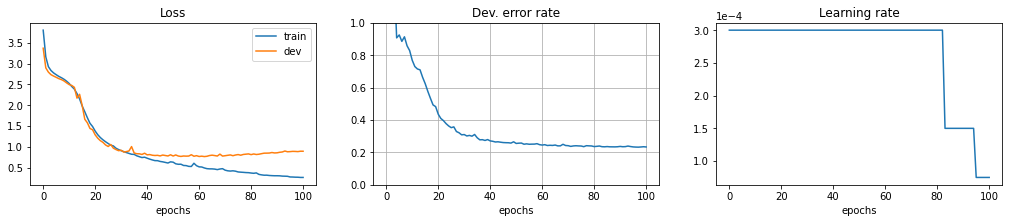

<Figure size 432x288 with 0 Axes>

In [3]:
plotLearning("config/default/history.csv")

In [14]:
from torch.autograd import Variable
import torch.utils.data

batch_size = cfg['train']['batch_size']
input_dim = 28 * 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for step, (xs, xlens, ys) in enumerate(train_loader):
    xs = xs.to(device) 
    ys = ys.to(device)
    #inputs = Variable(data.resize_(batch_size, input_dim))

modeled_data = model(xs, xlens, ys) #model(inputs)
print("modeled_data (loss) = ", modeled_data)
print("xs = ", xs)
print("ys = ", ys)
#model_data = modeled_data[0].reshape(batch_size, input_dim)
#print(input_data)        
#plt.imshow(model_data[0].detach().numpy().reshape(28, 28), cmap='gray')
#plt.show(block=True)

modeled_data (loss) =  tensor(0.1191, device='cuda:0', grad_fn=<NllLossBackward>)
xs =  tensor([[[-15.9424, -15.9424, -15.9424,  ..., -11.8081, -11.4297, -11.8080],
         [-15.9424, -15.9424, -15.9424,  ..., -11.6699, -11.4068, -11.5096],
         [-15.9424, -15.9424, -15.9424,  ..., -11.9081, -11.9406, -11.4121],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[-15.9424, -15.9424, -15.9424,  ..., -11.5195, -11.7500, -11.9929],
         [-15.9424, -15.9424, -15.9424,  ..., -10.7594, -10.7866, -11.4195],
         [-15.9424, -15.9424, -15.9424,  ..., -11.2772, -11.6889, -11.8462],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0

### Eval

In [15]:
# Restore checkpoint
info = torch.load("config/default/best.pth")
split = 'test'
print ("Dev. error rate of checkpoint: %.4f @epoch: %d" % (info['dev_error'], info['epoch']))
    
# Build model
tokenizer = torch.load('tokenizer.pth')
model = KalmanVAE(input_size=cfg['model']['input_size'],
            target_size=len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            activation=cfg['model']['activation'],
            drop_p=cfg['model']['drop_p'])
 
model.load_state_dict(info['weights'])
model.eval() 
model.cuda()

# Evaluate
error = eval_utils.get_error(train_loader, model)
print ("Error rate on %s set = %.4f" % (split, error))

Dev. error rate of checkpoint: 0.2324 @epoch: 97
Calculating error rate ... (#batch: 58/58)
Error rate on test set = 0.0584


### Plot Training & Eval time

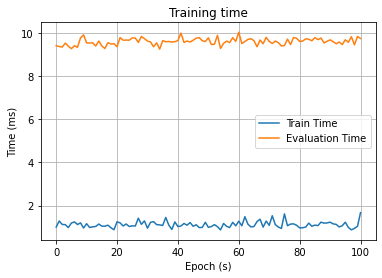

In [16]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = train_epoch_durations
#calculate the values for the Gaussian curve
x = np.arange(len(train_epoch_durations))
#plot the Gaussian curve
ax.plot(x, y, label = "Train Time")

ax.set(xlabel='Epoch (s)', ylabel='Time (ms)',
       title='Training time')

xe = np.arange(len(eval_epoch_durations))
ye = eval_epoch_durations
#plot sine wave
ax.plot(xe, ye, label = "Evaluation Time")

ax.grid()

#show the legend
plt.legend()
plt.show()

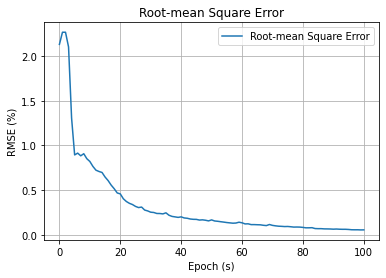

<Figure size 432x288 with 0 Axes>

In [24]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = RMS
#calculate the values for the Gaussian curve
x = np.arange(len(RMS))
#plot the Gaussian curve
ax.plot(x, y, label = "Root-mean Square Error")

ax.set(xlabel='Epoch (s)', ylabel='RMSE (%)',
       title='Root-mean Square Error')

ax.grid()

#show the legend
plt.legend()
plt.show()
plt.savefig('img/rmse-ekf.pdf')
plt.savefig('img/rmse-ekf.png')

#### Inference auxiliary method

In [18]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import argparse


def showAttention(predictions, attentions):
    output_words = predictions.split()
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_yticklabels([''] + output_words)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Inference

Predict:
b ah tcl dh iy ix f axr m ey sh en ah n dh ax dcl d ay n ae m ix kcl s ax v pcl p aa pcl p y ix l ey sh en w ax z ao f en kcl k w ay tcl m ix s l iy dx ix ng h#
Ground-truth:
h# b ah tcl dh iy ix f axr m ey sh en ah n dh ah dcl d ay n ae m ih kcl s ix v pcl p aa pcl p y ix l ey sh ix n w ax z ao f en kcl k w ay tcl m ix s l iy dx ix ng h#



/home/jay/.conda/envs/jay/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


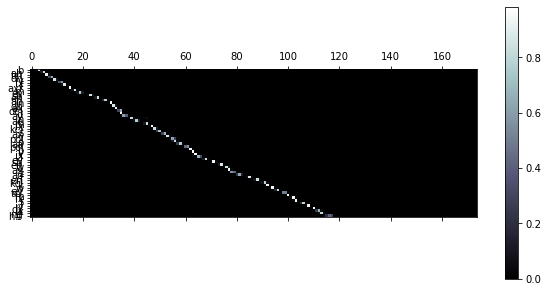

Predict:
dh ax hv ao n tcl t ix dcl hv aw s w ax z ix hv ih tcl d ux tcl t ax-h aw tcl s tcl t ae n dcl ix ng ao dx iy ow v ih zh w el ax f eh kcl k tcl s h#
Ground-truth:
h# dh ax hv ao n tcl t ix dcl hv aw s w ax z ix hv ih tcl d ux tcl t ax-h aw tcl s tcl t ae n dcl ih ng ao dx iy ow v ih zh w ax l ax f eh kcl k tcl s h#



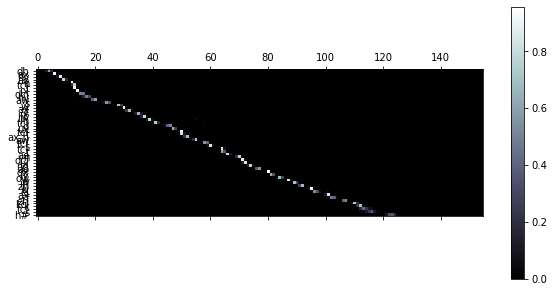

Predict:
y ux v ix n q ay ow kcl k ey zh l iy gcl g eh tcl t dh m ah n d ey bcl b l uw z h#
Ground-truth:
h# iy v ih n q ay ow kcl k ey zh l ix gcl g eh tcl t dh m ah n d ey bcl b l ux z h#



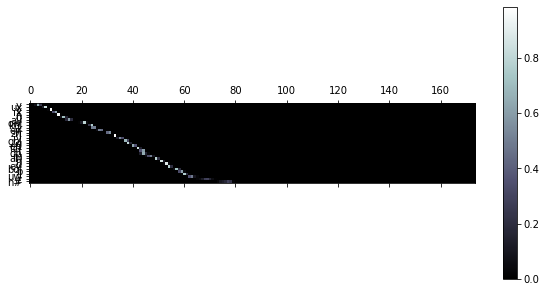

Predict:
hh iy r ih m eh m bcl b er dx ih s tcl t ao r iy hv iy hv eh dcl d r eh dx ih z ix y ux th h#
Ground-truth:
h# hh iy r ih m eh m bcl b er dx ih s tcl t ao r iy hv iy hv eh dcl d r eh dx ih z ix y ux th h#



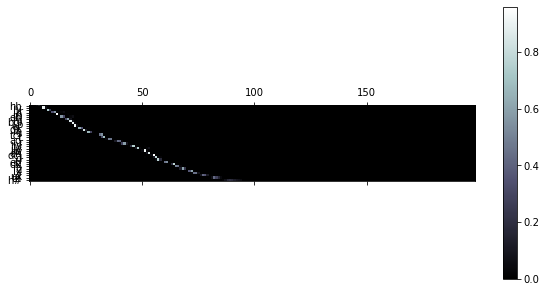

Predict:
dh ax gcl g ao r dcl jh ix s bcl b ah dx axr f l ay q ey dx ax l aa dx ax n eh kcl t axr h#
Ground-truth:
h# dh ax gcl g ao r dcl zh ix s bcl b ah dx axr f l ay q ey dx ax l aa dx ax n eh kcl t axr h#



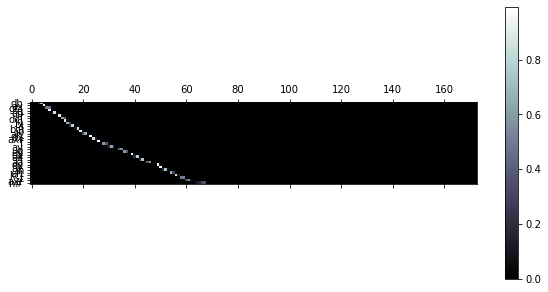

Predict:
dh ax m oy sh ch er m ay ay z ix z f r ax m q ay dcl d r aa pcl p s pau n aa tcl f r em tcl t ih axr z h#
Ground-truth:
h# dh ax m oy sh ch er m ay ay z ax-h z f r ax m q ay dcl d r aa pcl p s pau n aa tcl t f r em tcl t ih er s h#



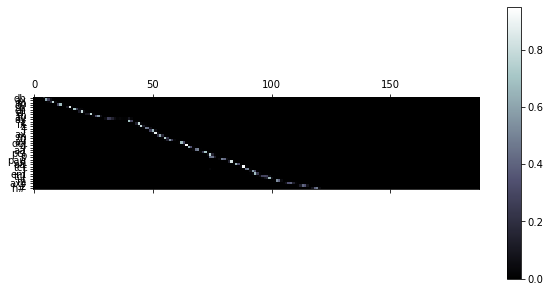

Predict:
dh ix pcl p ey sh ih n tcl q eh n dh ix s er dcl jh ix n axr bcl b ow th r ix kcl k uw pcl p axr r ey dx iy ng f r ah m dh ax l ih ng kcl k th iy aa pcl p axr r ey sh en h#
Ground-truth:
h# dh ix pcl p ey sh ih n tcl ae n dh ix s er dcl jh ix n axr bcl b ow th r ix kcl k uw pcl p axr r ey dx iy ng f r ah m dh ax l ih ng gcl g th iy aa pcl p axr r ey sh en h#



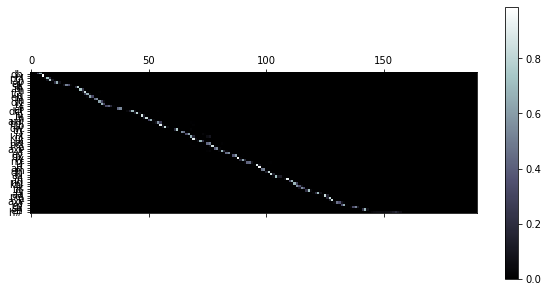

Predict:
dh ow z hh uw tcl t iy tcl ch v ae y uw z f er s tcl t pau q aa bcl b aa l ih sh pau ch iy dx iy ng h#
Ground-truth:
h# dh ow z hh uw tcl t iy tcl ch v ae l y uh z f er s tcl t pau q aa bcl b aa l ih sh epi ch iy dx iy ng h#



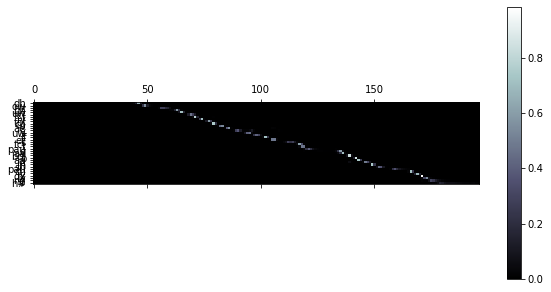

Predict:
dh ey w axr n aa tcl y eh tcl p axr pcl p eh axr tcl t ux ix kcl s eh pcl t ih dcl q ae z q ih r m iy dcl d iy ix bcl b el h#
Ground-truth:
h# dh ey w axr n aa tcl y eh tcl p axr pcl p eh r dcl t ux ix kcl s eh pcl t ih tcl q ae z q iy r ax m iy dcl d iy ix bcl b el h#



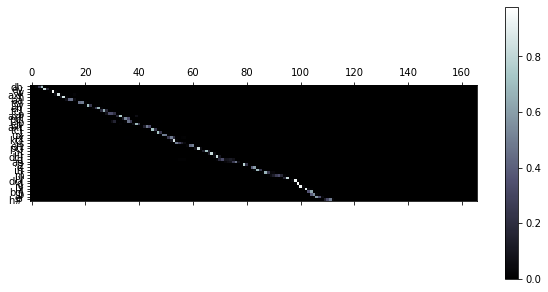

Predict:
q eh n dcl d ih v eh l ax pcl p ih ng f ih l m ax pau m eh nx iy tcl t aa kcl k s ix kcl k eh m ax kcl k el z q aa r y ux z dcl d h#
Ground-truth:
h# q eh n dcl d ih v eh l ax pcl p ih ng f ih l m ax pau m eh nx iy tcl t aa kcl k s ix kcl k eh m ax kcl k el z q aa r y ux z dcl d h#



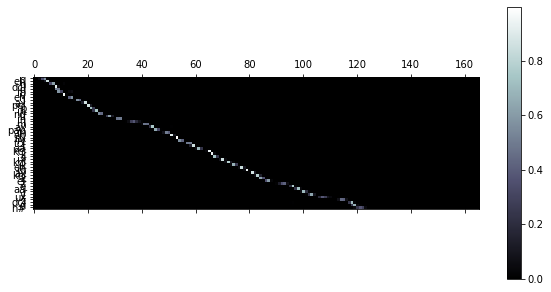

Predict:
d ix z kcl k r iy ow kcl k uh kcl k iy ng y ux z kcl k er iy h#
Ground-truth:
h# d ix z kcl k r iy ow kcl k uh kcl k iy ng y ux z kcl k er iy h#



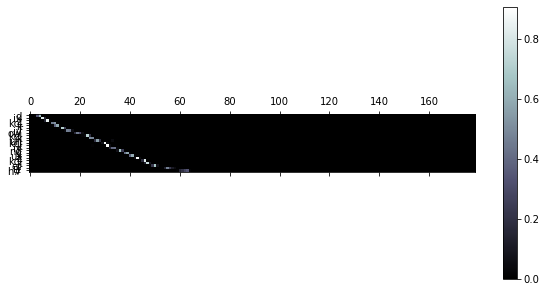

Predict:
q ix z axr r ih l ae kcl k s q ow v ae tcl m ax s f ih r iy n ah f tcl t ux hh eh l pcl p axr aw tcl g r ow dh iy z tcl t r ey tcl t s h#
Ground-truth:
h# q ix z axr r ih l ae kcl k s tcl ow m ae q m ax s f ih r iy n ah f tcl t ux hh eh l pcl p er aw tcl g r ow dh iy z tcl t r ey tcl s h#



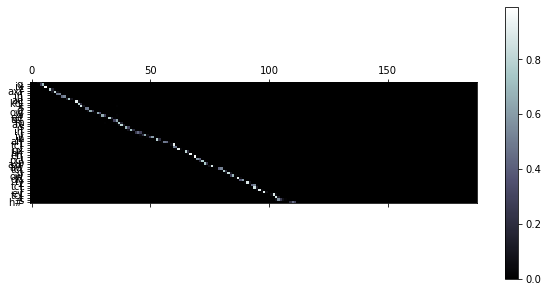

Predict:
ix tcl s hh aa r dcl t ix tcl t eh l ax n axr r ih zh en el f r ah m ax f ao r dcl jh axr iy h#
Ground-truth:
h# ix tcl s hh aa r dcl t ix tcl t eh l ax nx ax r ih jh en el f axr m ax f ao r dcl jh axr iy h#



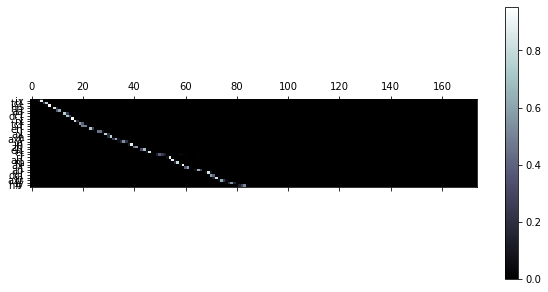

Predict:
dh ih s w ax z iy z iy f er ah s h#
Ground-truth:
h# dh ih s uh z iy z iy f er ah s h#



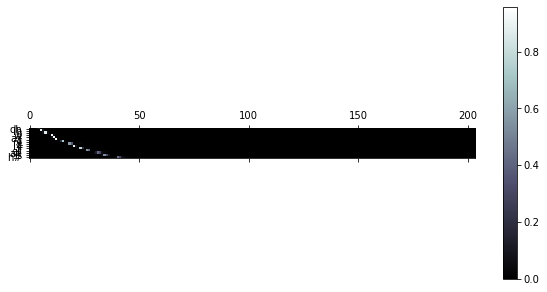

Predict:
d ay ae n m ey s pcl p l er dcl jh em bcl b aa tcl t axr kcl k oy z n eh kcl k l ax s h#
Ground-truth:
h# d ay ae n m ey s pcl p l er dcl jh em bcl b aa tcl t axr kcl k oy z n eh kcl k l ax s h#



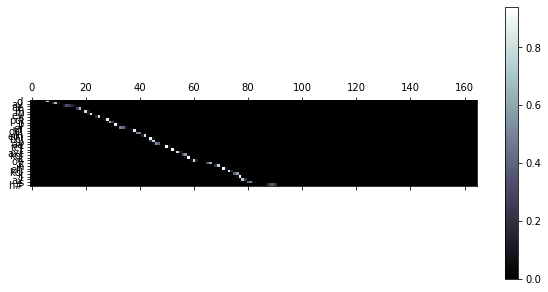

Predict:
dh ax m ux z iy ah m hv ay er z epi r ix zh ih sh ix n z eh v r iy q iy v n ix ng h#
Ground-truth:
h# dh ax m ux z iy ah m hv ay er zh m ux zh ih sh ix n z eh v r iy q iy v n ix ng h#



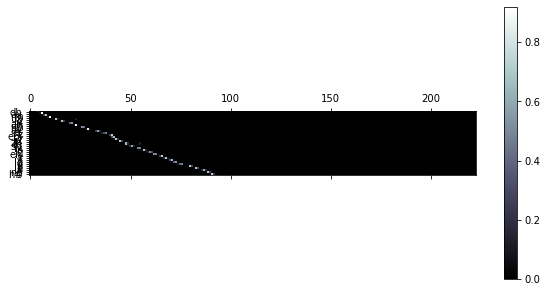

Predict:
s tcl t ih m y ix l ey dx iy n dcl d ix s kcl k ah sh en z kcl k iy pcl p s tcl t ux dx eh n tcl t s ax tcl t ih n sh ix n h#
Ground-truth:
h# s tcl t ih m y ix l ey dx iy n dcl d ix s kcl k ah sh en z kcl k iy pcl p s tcl t ux dx eh n tcl t s ax tcl t ih n sh ix n h#



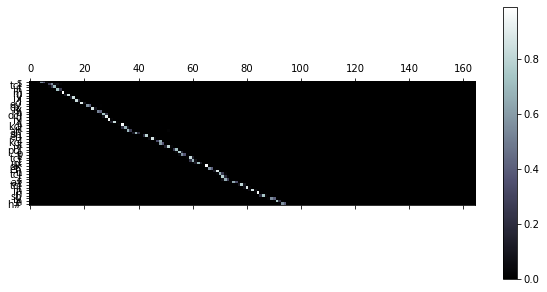

Predict:
q eh z kcl k ow ao th axr z epi w iy pcl p r ix z eh nx axr dx aa r n ux bcl b uh kcl k pau t ux dh ah hh ao dx iy q ao dx iy ix n s h#
Ground-truth:
h# q eh z kcl k ow ao th axr z pau w iy pcl p r ix z eh nx axr dx aa r n ux bcl b uh kcl k pau t ux dh ah hh ao dx iy q ao dx iy ix n s h#



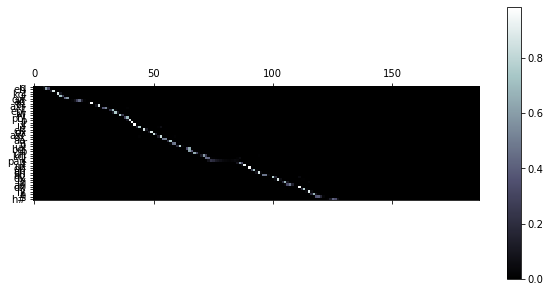

Predict:
t r eh s pcl p ae s ix ng ix z f axr bcl b ih dx en ix n s ah bcl jh ih kcl t ix pcl p eh nx el tcl t iy h#
Ground-truth:
h# t r eh s pcl p ae s ih ng ix z f axr bcl b ih dx en ix n s ah bcl jh ih kcl t ix pcl p eh nx el tcl t iy h#



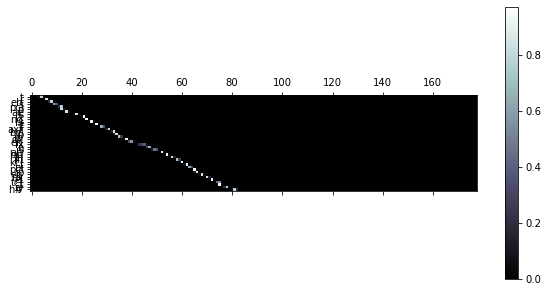

Predict:
hh er pcl p ix z ih sh ix ng kcl k ah v axr z ax n ah m bcl r ax ax dcl d ey l iy tcl t ae s kcl k aa m ax n tcl t ux ix nx iy s ow sh ix dcl d axr eh kcl t h#
Ground-truth:
h# hh er pcl p ix z ih sh ix ng kcl k ah v axr z ax n ah m bcl axr ax dcl d ey l iy tcl t ae s kcl k aa m ax n tcl t ux ix nx iy s ow sh ix dcl d axr eh kcl t ax-h h#



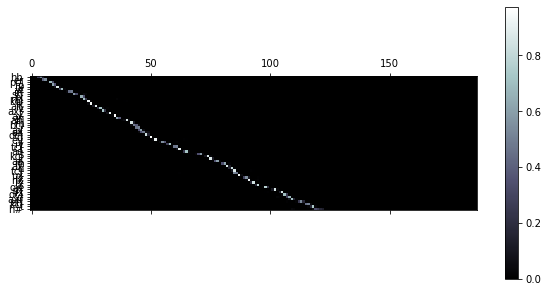

Predict:
hh iy w ah z ax bcl b ah v ao l ax f r eh n s iy kcl k axr q ao m ow s tcl p ax th eh dx ih kcl k ix n ix z q iy gcl axr n ax s tcl t ax-h bcl b iy l ay kcl t h#
Ground-truth:
h# hh iy w ah z ax bcl b ah v ao l ax f r eh n s iy kcl k axr q ao m ow s tcl p ax th eh dx ix kcl k ix n ix z q iy gcl axr n ax s tcl t ax-h bcl b iy l ay kcl t h#



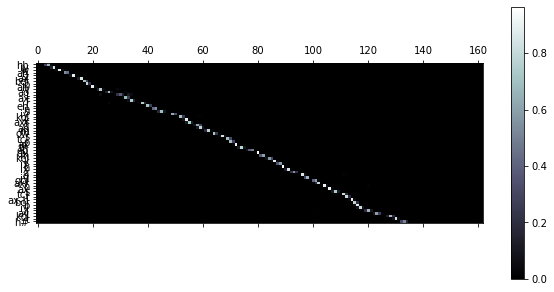

Predict:
s tcl t eh f kcl k ix dcl b eh r l iy hv ae n dcl d el dh ax s ay kcl k el aa dcl jh ax-h kcl k el tcl t r aa m ax h#
Ground-truth:
h# s tcl t eh f kcl k ix dcl b eh axr l iy hh ae n dcl d el dh ax s ay kcl k el aa dcl jh ax-h kcl k el tcl t r aa m ax h#



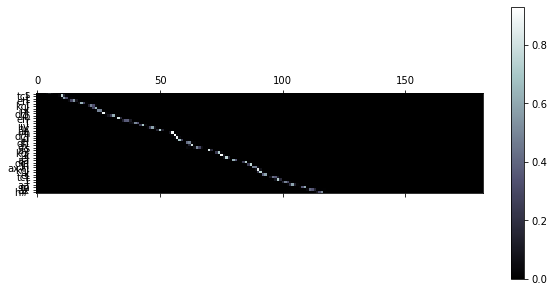

Predict:
d ah z dh ih s bcl b aa dh er y ux h#
Ground-truth:
h# d ah z dh ih s bcl b aa dh axr y ux h#



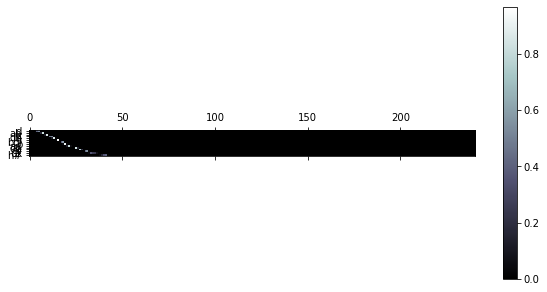

Predict:
w iy l ay kcl b l ux tcl ch iy z bcl b ah tcl v ih kcl t axr pcl p axr f er s epi w ih s tcl ch iy z h#
Ground-truth:
h# w iy l ay kcl b l ux tcl ch iy z bcl b ah tcl v ih kcl t axr pcl p axr f er s epi w ih s tcl ch iy z h#



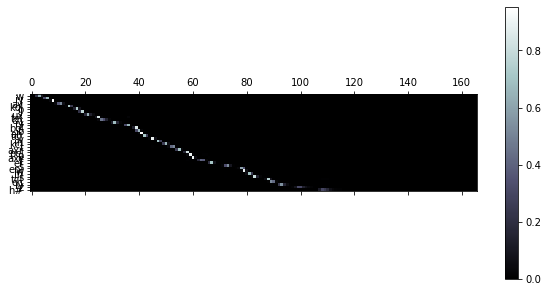

Predict:
hh ih z aa r m ux v s w ih f l iy v ay l ax n l iy pau w ah n tcl t s tcl t w ay s h#
Ground-truth:
h# hh ih z aa r m ux v s w ih f l iy v ay l en q l iy pau w ah n tcl t s tcl t w ay s h#



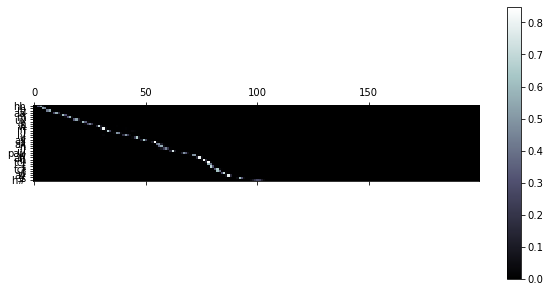

Predict:
m eh l ax n kcl k aa l iy q ah bcl b s eh sh en h#
Ground-truth:
h# m eh l ax n kcl k aa l iy q ax bcl b s eh sh en h#



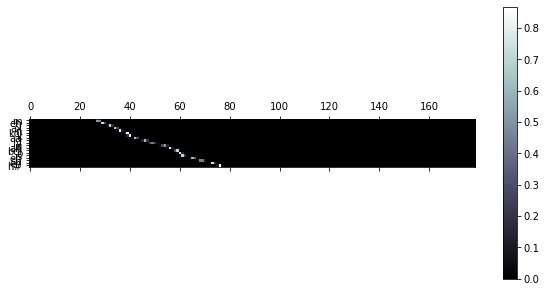

Predict:
dh ey w er ix nx ih z epi w eh l pcl p ey dx ix z dh ey sh uh dx ah v bcl b eh n h#
Ground-truth:
h# dh ey w er ih nx eh z epi w eh l pcl p ey dx ix z dh ey sh uh dx ah v bcl b eh n h#



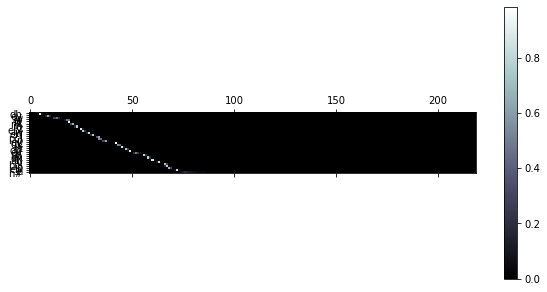

Predict:
q ae n dcl dh iy z hv aa r dx iy tcl t r ae l er z ao r n aa dx ah n ax pcl p r iy sh iy ey dx ix dcl t ax-h dcl d ey h#
Ground-truth:
h# q ae n dcl dh iy z hv aa r dx iy tcl t r ae l axr z aa r n aa dx ah n ax pcl p r iy sh iy ey dx ix dcl t ax-h dcl d ey h#



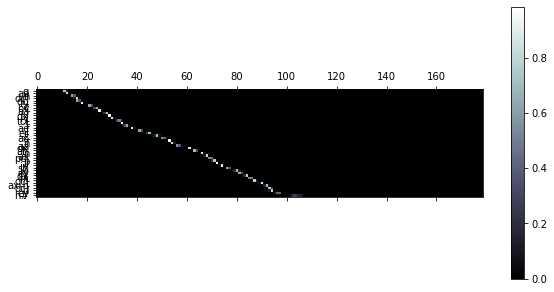

Predict:
dh iy eh s ey q ah n dcl d ih n ay ax bcl b l iy r ix f l eh kcl k s aa r v y uw ey bcl b l iy h#
Ground-truth:
h# dh iy eh s ey q ah n dcl d ih n ay ax bcl b l iy r iy f l eh kcl k s aa r v y uw ey bcl b l ix h#



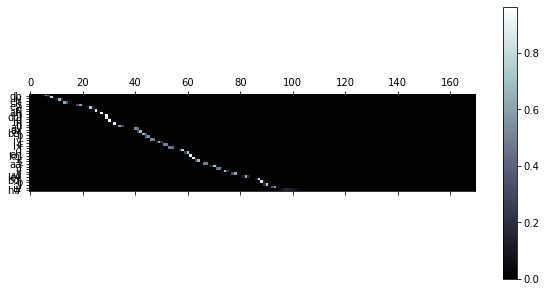

Predict:
g ih dx ih kcl k ae l ax kcl k ow kcl k ae tcl t ax-h kcl k iy pcl p h#
Ground-truth:
h# g ih dx ih kcl k ae l ih kcl k ow kcl k ae tcl t ax-h kcl k iy pcl p h#



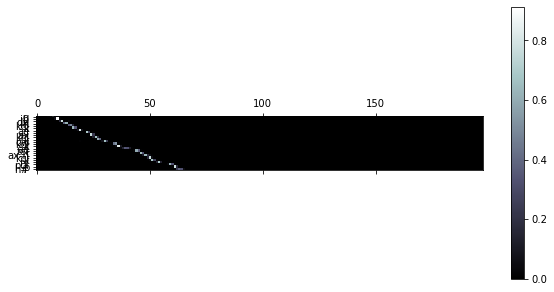

Predict:
y er hv ae v ix ng ax m ih z r ax bcl b el tcl t ay m aa r n tcl ch ix h#
Ground-truth:
h# y er hv ae v ix ng ax m ih z r ax bcl b el tcl t ay m aa r n tcl ch ix h#



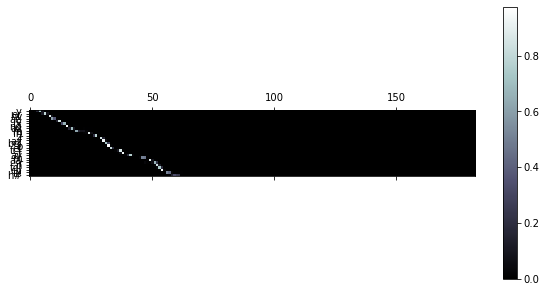

Predict:
b aa bcl b ae n d ix dcl jh bcl b ow th epi w ux n z w ix s kcl k ih l v ax dcl d aa kcl t axr h#
Ground-truth:
h# b aa bcl b ae n d ix dcl jh bcl b ow th epi w ux n z w dh ix s kcl k ih l v ax dcl d aa kcl t axr h#



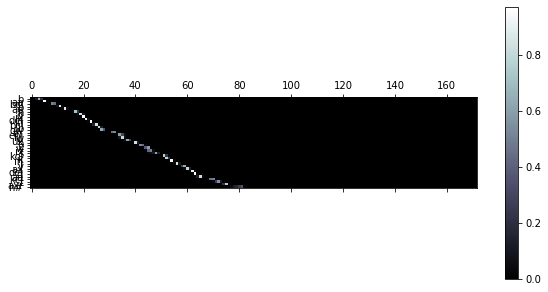

Predict:
t r eh s pcl p ae s ix ng ih z f axr bcl b ih dcl en ix n s ah bcl jh ih kcl t ax-h pcl p eh nx el tcl t iy h#
Ground-truth:
h# t r eh s pcl p ae s ix ng ih z f axr bcl b ih dcl en ix n s ah bcl jh ih kcl t ax-h pcl p eh nx el tcl t iy h#



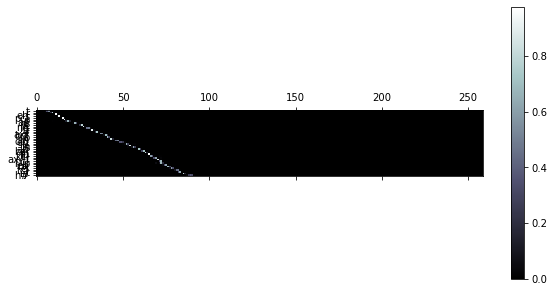

Predict:
k y er iy aa s ix dx iy ix n m iy dcl d iy aa kcl k axr dcl d iy s eh l dcl d ax m kcl k ow ax gcl z ih s tcl t h#
Ground-truth:
h# k y er iy ah s ix tcl t iy ix n m iy dcl d iy aa kcl k r ix tcl t iy s eh l dcl d ax m kcl k ow ax gcl z ih s tcl t h#



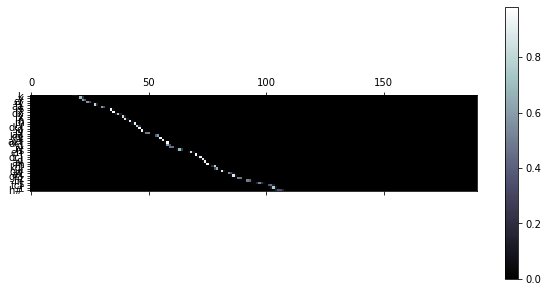

Predict:
dh ih l r ow l ao f q ix n ix n ah dh axr dcl d ey h#
Ground-truth:
h# dh ih l r ow l ao f q ih n ax n ah dh er dcl d ey h#



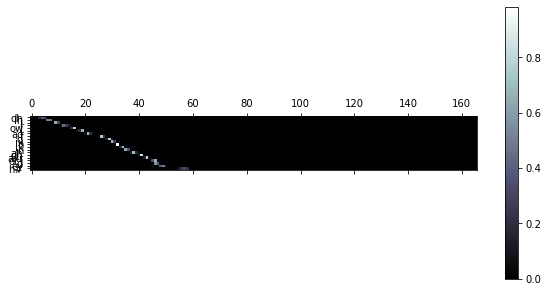

Predict:
dh iy z epi n iy dcl jh ux zh l iy kcl k en s er n axr r ix dcl d ah kcl sh epi en ax v gcl g ih l ax n s ax m r ix l iy f ax v tcl t eh n sh ix n h#
Ground-truth:
h# dh iy z epi n iy dcl jh ux zh l iy k ix n s axr n dh axr r ih dcl d ah kcl sh epi en ix v gcl g ih l en s ax m r ix l iy f ax v tcl t eh n sh ix n h#



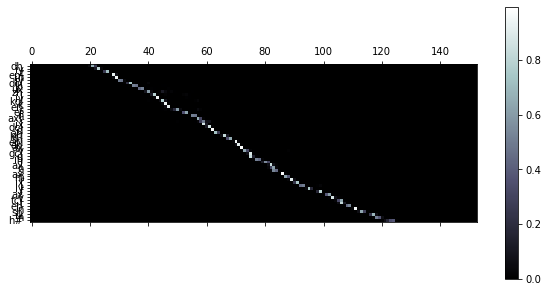

Predict:
ix f iy y ux s pcl p aa r kcl k ix ng ix tcl t eh n dcl ax n tcl s pau k eh n ey bcl b iy r ix pcl p l ey s bcl b aa q aa dx ax m aa dx ix kcl p aa r kcl k eng gcl g ey tcl t s h#
Ground-truth:
h# ix f ux y ux s pcl p aa r kcl k ix ng ax tcl t eh n dcl ax n tcl s pau k eh n ey bcl b iy r ax pcl p l ey s tcl b ay q ao dx ax m aa dx ix kcl p aa r kcl k eng gcl g ey tcl t s h#



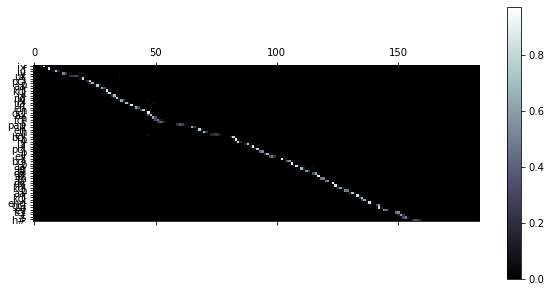

Predict:
dh iy ae v ax l ae n tcl ch tcl t r ih gcl er dx ax m ay nx axr q er th kcl k w ey kcl k h#
Ground-truth:
h# dh iy ae v ax l ae n tcl ch tcl t r ih gcl er dx ax m ay nx axr q er th kcl k w ey kcl k h#



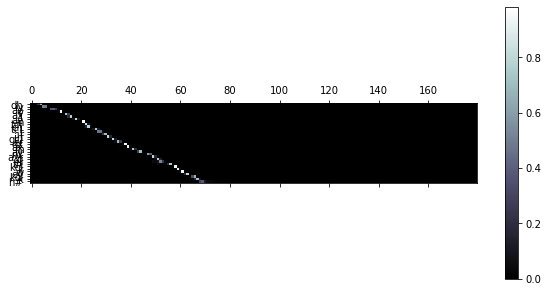

Predict:
ey l ah dh er hv ae n bcl b ae gcl w uh dcl b iy ix s ux dx ax bcl b el gcl g ih f tcl t h#
Ground-truth:
h# ey l eh dh er hv ae n dcl b ae gcl w uh dcl b iy ix s ux dx ax bcl b el gcl g ih f tcl t h#



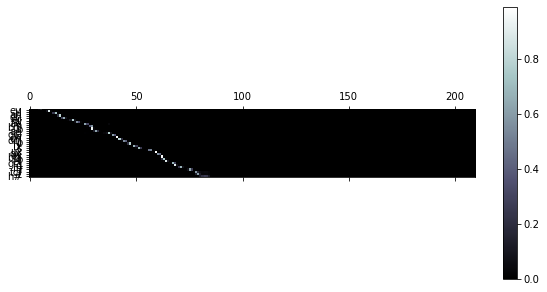

Predict:
q ow n l iy q ih ng kcl k em pcl p l iy tcl pau q ih m pcl p er f ix kcl k th ih ng z epi m ux v tcl t ao r dcl z epi w ah tcl dh ey l ae kcl k h#
Ground-truth:
h# q ow n l ih q ix ng kcl k em pcl p l iy tcl pau q ih m pcl p er f ix kcl k th ih ng z epi m ux v tcl t ao axr dcl z epi w ah tcl dh ey l ae kcl k h#



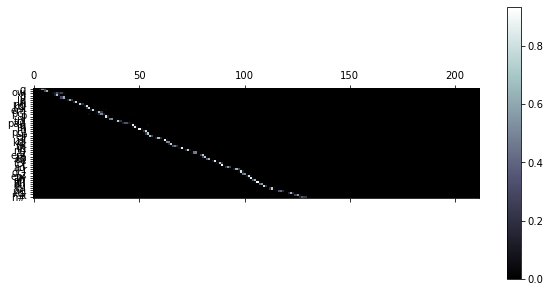

Predict:
s ow r uw l z epi w iy m ey dcl d ix n ah n ax bcl b ae sh tcl t kcl k ax l ux zh en h#
Ground-truth:
h# s ow r uw l z epi w iy m ey dcl d ix n ah n ax bcl b ae sh tcl t kcl k ax l uw zh en h#



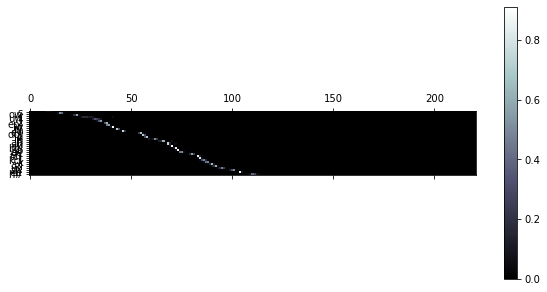

Predict:
dh ix tcl t ae kcl k s ix kcl k ae bcl b r ow kcl d aw nx ix n kcl k ao z ax tcl t r ae f ix kcl jh ae m h#
Ground-truth:
h# dh ix tcl t ae kcl k s ix kcl k ae bcl b r ow kcl d aw nx ih n kcl k ao z ax tcl t r ae f ix kcl jh ae m h#



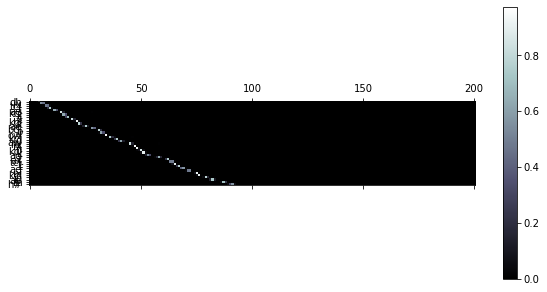

Predict:
dh ih dcl d r ah ng kcl k axr dcl d ih z ah s ow sh el q aw tcl k ae s tcl t h#
Ground-truth:
h# dh ih dcl d r ah ng kcl k axr dcl d ih z ah s ow sh ix l q aw tcl k ae s tcl t h#



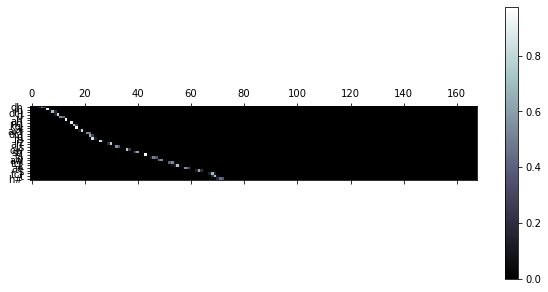

Predict:
hh ix z f ih ng er z f eh l tcl t ah bcl s er dcl d l ih th ih kcl k ix n kcl k l ah m z iy h#
Ground-truth:
h# hh ix z f ih ng axr z f eh l tcl t ah bcl s er dcl d l ih th ih kcl k ix n kcl k l ah m z iy h#



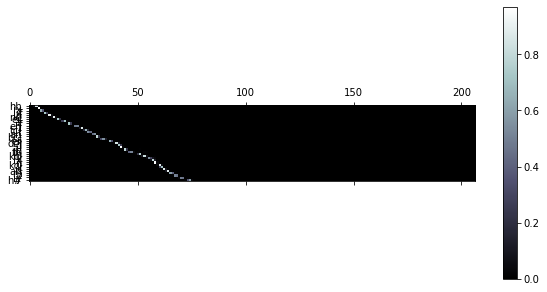

Predict:
q ae n ix q eh r iy ix sh eh l tcl t axr dcl d f r em epi s tcl r ao ng w ih n z epi m ey bcl b iy hv ay l iy dcl d ix z ay axr bcl b el pau f ao r eh kcl k r iy ey sh en y ux s h#
Ground-truth:
h# q ae n ix q eh r iy ix sh eh l tcl t axr dcl d f r em epi s tcl r ao ng w ih n z epi m ey bcl b iy hv ay l iy dcl d ix z ay axr bcl b el pau f ao r eh kcl k r iy ey sh en y ux s h#



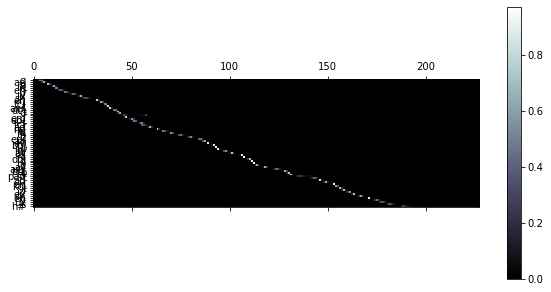

Predict:
dh ax w ao dx axr kcl k ax n tcl t ey n dcl t ux m ah tcl ch kcl k l ao r iy nx ix n s tcl t ah ng ix z ay z h#
Ground-truth:
h# dh ax w ao dx axr kcl k ax n tcl t ey n dcl t ux m ah tcl ch kcl k l ao r iy nx ix n s tcl t ah ng ix z ay z h#



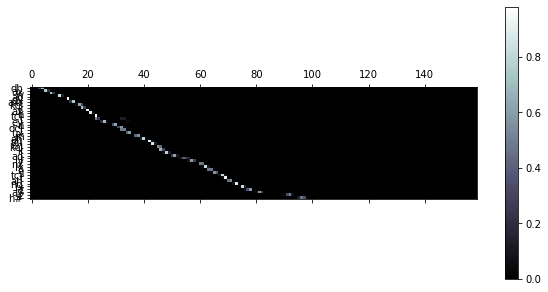

Predict:
r ih m eh m bcl b er tcl t uw ah l aw q ay dcl d eh nx ix kcl k el tcl t w ih n z tcl t ix q ih n tcl t axr f r iy l iy h#
Ground-truth:
h# r ih m eh m bcl b er tcl t uw ah l aw q ay dcl d eh nx ix kcl k el tcl t w ih n z tcl t ix q eh n tcl t axr f r iy l iy h#



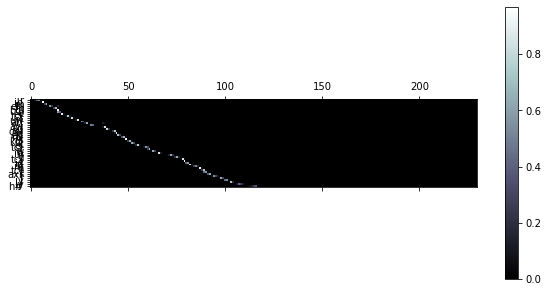

Predict:
dh ix tcl t ux aa dx ix s ix kcl s sh ey n z aa dx ix gcl g r ae f s h#
Ground-truth:
h# dh ix tcl t ux aa dx ix s ix kcl s sh ey n zh ao dx ix gcl g r ae f s h#



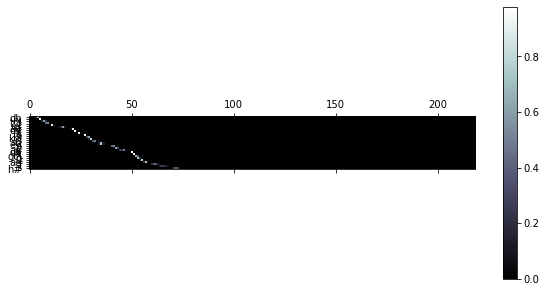

Predict:
dh ah s f aa r dh iy ix dcl v ae n s ax z epi m ey dcl d ix bcl b ix n aa l m ax s tcl t ix n tcl t ay axr l iy ax l ao ng f ah ng kcl k sh epi n el l ay n z h#
Ground-truth:
h# dh ah s f aa r dh iy ix dcl v ae n s ax z m ey dcl d ix bcl b ih n aa l m ax s tcl t ix n tcl t ay axr l iy ix l ao ng f ah ng k sh epi n el l ay n s h#



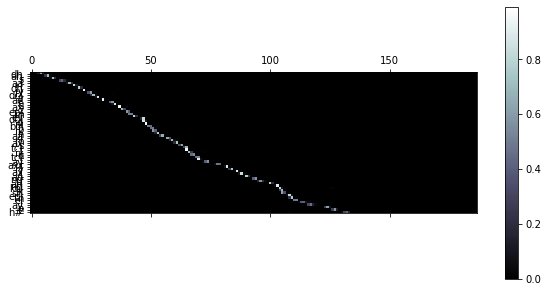

Predict:
dh ax m ow s tcl r iy s en tcl jh iy ax l aa dcl jh ax-h kcl k el s er v ey f aw n dcl s ay z m ix kcl k ae kcl t ih v ix dx iy h#
Ground-truth:
h# dh ax m ow s tcl r iy s en tcl jh iy ax l aa dcl jh ax-h kcl k el s er v ey f aw n dcl s ay z m ix kcl k ae kcl t ih v ix dx iy h#



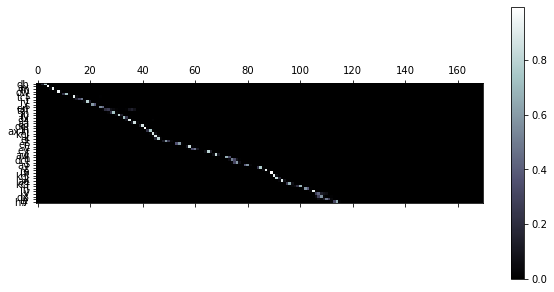

Predict:
w ah n s y ux f ih n ih sh gcl g r iy s ix ng y axr tcl ch ey n pau b iy sh er dcl d ax w aa sh th er ax l iy h#
Ground-truth:
h# w ah n s y ux f ih n ih sh gcl g r iy s ih eng y axr tcl ch ey n pau b iy sh er dx uw w aa sh th er ax l iy h#



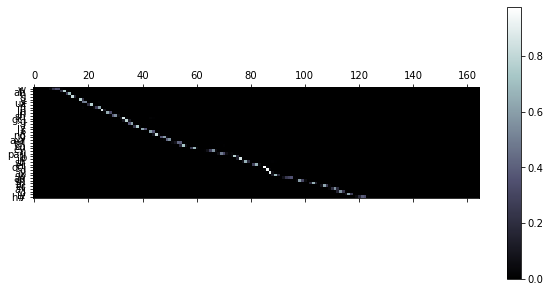

Predict:
y ao w ih z kcl k ah m ah pcl w ix th pcl p ae th ax l aa dcl jh ix kcl k el ax gcl g z ae m pcl p el z h#
Ground-truth:
h# y ax ao w ih z kcl k ah m ah pcl w ix th pcl p ae th ax l ao dcl jh ix kcl k el ax gcl g z ae m pcl p el z h#



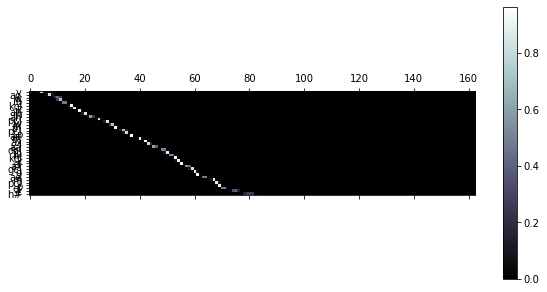

Predict:
aa r hh aa l ah dcl d ey q ey pcl p r ix n z ax v ey l ax bcl b el tcl t uw ah s h#
Ground-truth:
h# q aa r hh aa l ah dcl d ey q ey pcl p r ix n z ax v ey l ax bcl b el tcl t ax w ah s h#



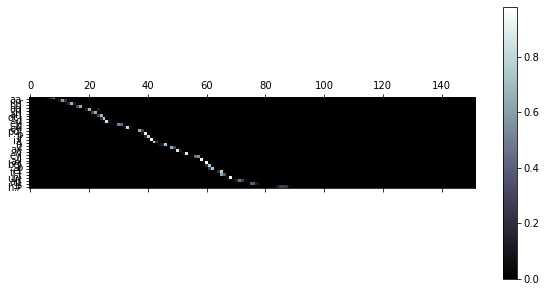

Predict:
b ay ng ix th er bcl b r eh dcl d hv ao r s kcl k w aa axr z q ix n tcl t uw ih sh en eh kcl k s pcl p axr tcl t iy z h#
Ground-truth:
h# b ay ng ix th er bcl b r eh dcl d hv ao r s epi kcl k w aa axr z q ix n tcl t uw ih sh en eh kcl k s pcl p axr tcl t iy z h#



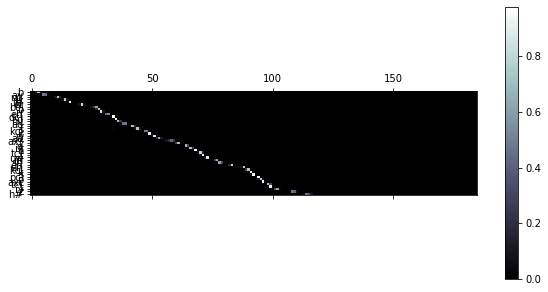

Predict:
hh uw tcl t uh kcl k dh ix kcl k ay ae kcl k dcl d aw n dh ax bcl b ay y ux h#
Ground-truth:
h# hh uw tcl t uh kcl k dh ix kcl k ay ae kcl k dcl d aw n dh ax bcl b ay y ux h#



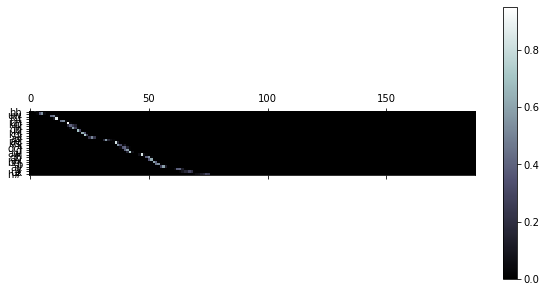

Predict:
dh ix tcl t aa dcl l er f aw n dcl ix kcl k l ae m sh eh l n ih er dh ix kcl k ae m pcl p s ay tcl t h#
Ground-truth:
h# dh ih tcl t aa dcl l er f aw n dcl ix kcl k l ae m sh eh l n ih er dh ix kcl k ae m pcl s ay tcl t h#



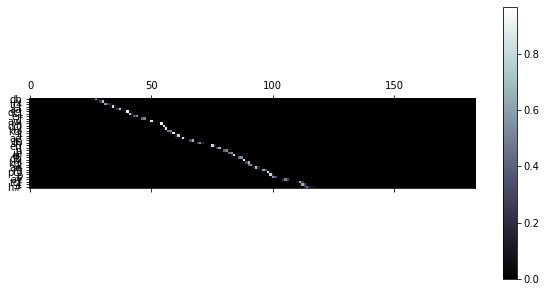

Predict:
q ax l aw iy tcl ch tcl ch ay l dcl d ix hv eh v ax n ay s pcl p aa pcl h#
Ground-truth:
h# q ax l aw iy tcl ch tcl ch ay ax l dcl d ix hv eh v ax n ay s pcl p aa pcl h#



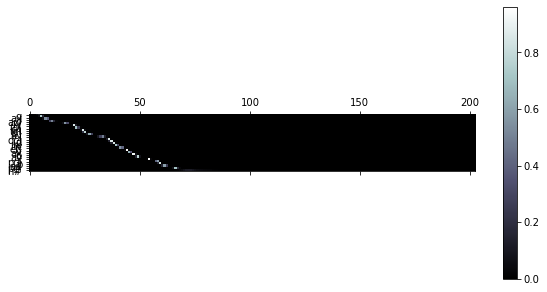

Predict:
w uh kcl k ix dcl b eh r l ix s iy dh ax f iy y ao r dcl z pau f r uw dh ax s n ow f l er ix s h#
Ground-truth:
h# w ax kcl k ix dcl b eh r l ix s iy dh ax f iy y ao r dcl z pau th r uw dh ax s n ow f l er ix s h#



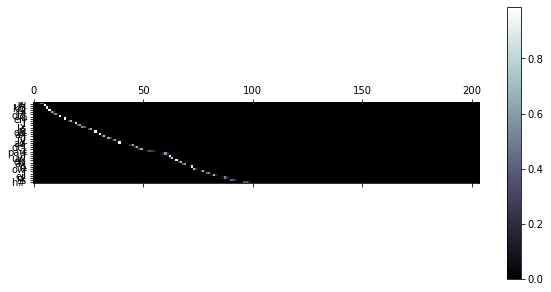

In [19]:
# Inference
with torch.no_grad():
    for (x, xlens, y) in train_loader:
        predictions, attentions = model(x.cuda(), xlens)
        predictions, attentions = predictions[0], attentions[0]
        predictions = tokenizer.decode(predictions)
        attentions = attentions[:len(predictions.split())].cpu().numpy()   # (target_length, source_length)
        ground_truth = tokenizer.decode(y[0])
        print ("Predict:")
        print (predictions)
        print ("Ground-truth:")
        print (ground_truth)
        print ()
        showAttention(predictions, attentions)

In [23]:
epoch = 0
with open('config/default/timing.txt', 'w') as filehandle:
    for (train_epoch_duration, eval_epoch_duration, RMSE) in zip(train_epoch_durations, eval_epoch_durations, RMS):
        msg = '%d, %s, %s, %s \n' % (epoch, train_epoch_duration, eval_epoch_duration, RMSE)
        #print(msg)
        epoch = epoch +1 
        filehandle.write(msg)

0, 1.0041825771331787, 9.41182827949524, 2.129441968265288 

1, 1.288419246673584, 9.375907182693481, 2.2649028347298983 

2, 1.1261014938354492, 9.34975790977478, 2.26491709752184 

3, 1.1188805103302002, 9.533160924911499, 2.100909252986272 

4, 0.9817235469818115, 9.390249729156494, 1.305986806917454 

5, 1.193688154220581, 9.275468349456787, 0.8946906756997682 

6, 1.244032382965088, 9.41153621673584, 0.9147798181494028 

7, 1.124603271484375, 9.340007305145264, 0.8847067213407025 

8, 1.2009553909301758, 9.77381181716919, 0.9080620431449457 

9, 0.9615023136138916, 9.915529251098633, 0.8526439650561597 

10, 1.1623127460479736, 9.545044183731079, 0.8214298448921377 

11, 0.986640453338623, 9.535686731338501, 0.7665109645213051 

12, 1.0180742740631104, 9.548721313476562, 0.7243073631663398 

13, 1.0339794158935547, 9.398220300674438, 0.7096238188625423 

14, 1.1464028358459473, 9.628716468811035, 0.6986985202353361 

15, 1.050032615661621, 9.403181552886963, 0.6477803530041005 

1